# To-Dos

In [1]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [2]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [4]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [5]:
options(scipen = 999)

# Import Data

In [60]:
## 2018-12-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0857.csv')

## 2010-01-01 -- Complete DL Outage
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0900.csv')

## 2019-01-04 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1130.csv')

## 2019-01-06 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1125.csv')

## 2019-01-07 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1103.csv')

## 2019-01-08 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1117.csv')

## 2019-01-11 -- Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0902.csv')





df$dayofyear = as.Date(df$dayofyear)
df$grouping = as.character(df$grouping)

head(df)
str(df)

dayofyear,dayofweek,hourofday,q,bv,grouping
2018-10-04,4,0,41,24,training
2018-10-04,4,1,30,26,training
2018-10-04,4,2,35,18,training
2018-10-04,4,3,24,15,training
2018-10-04,4,4,30,19,training
2018-10-04,4,5,40,25,training


'data.frame':	2231 obs. of  6 variables:
 $ dayofyear: Date, format: "2018-10-04" "2018-10-04" ...
 $ dayofweek: int  4 4 4 4 4 4 4 4 4 4 ...
 $ hourofday: int  0 1 2 3 4 5 6 7 8 9 ...
 $ q        : int  41 30 35 24 30 40 66 98 137 151 ...
 $ bv       : int  24 26 18 15 19 25 45 75 92 118 ...
 $ grouping : chr  "training" "training" "training" "training" ...


# Clean the data

### Get Information on the "Session_Date"

In [61]:
getSessionInfo = function() {

    current.date = max(
        as.Date(df$dayofyear)
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

# str(getSessionInfo())
# getSessionInfo()

### Get Aggregated Data for the "Session_Date" (Test)

In [62]:
getSessionDataCumulative = function() {
    
    df.session = df[which(df$grouping == 'test'), ]

    session.point.estimates = 
        df.session %>%
        group_by(
            hourofday
        ) %>%
        transmute(
            q.session.cums = cumsum(q),
            dl.session.cums = cumsum(bv),
            ratio.session.cums = ifelse(
                cumsum(q) > 0,
                cumsum(bv)/cumsum(q),
                0
            )
        )
    
    return(session.point.estimates)
}

# str(getSessionDataCumulative())
# getSessionDataCumulative()

### Get Aggregated Data for History (Training)

In [63]:
df.hist = df[which(df$grouping == 'training'), ]
    
df.hist.mutate = 
    df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
    group_by(
        dayofyear
    ) %>%
    mutate(
        q.hist.cum = cumsum(q),
        dl.hist.cum = cumsum(bv)
    )
str(data.frame(df.hist.mutate))
head(data.frame(df.hist.mutate))
table(df.hist.mutate$hourofday)

'data.frame':	312 obs. of  8 variables:
 $ dayofyear  : Date, format: "2018-10-05" "2018-10-05" ...
 $ dayofweek  : int  5 5 5 5 5 5 5 5 5 5 ...
 $ hourofday  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q          : int  41 35 27 25 43 57 68 107 137 186 ...
 $ bv         : int  30 21 17 15 31 38 48 84 118 112 ...
 $ grouping   : chr  "training" "training" "training" "training" ...
 $ q.hist.cum : int  41 76 103 128 171 228 296 403 540 726 ...
 $ dl.hist.cum: int  30 51 68 83 114 152 200 284 402 514 ...


dayofyear,dayofweek,hourofday,q,bv,grouping,q.hist.cum,dl.hist.cum
2018-10-05,5,0,41,30,training,41,30
2018-10-05,5,1,35,21,training,76,51
2018-10-05,5,2,27,17,training,103,68
2018-10-05,5,3,25,15,training,128,83
2018-10-05,5,4,43,31,training,171,114
2018-10-05,5,5,57,38,training,228,152



 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

In [64]:
getHistoricalDataCumulative = function() {

    df.hist = df[which(df$grouping == 'training'), ]
    
    df.hist.mutate = 
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            dayofyear
        ) %>%
        mutate(
            q.hist.cum = cumsum(q),
            dl.hist.cum = cumsum(bv)
        )

    historical.point.estimates = 
        df.hist.mutate %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.hist.cums = sum(q.hist.cum),
            dl.hist.cums = sum(dl.hist.cum),
            r.hist.cums = sum(dl.hist.cum)/sum(q.hist.cum),
            n.hist.cums = sum(q.hist.cum),
            sd.q.hist.cums = sd(q.hist.cum),
            sd.dl.hist.cums = sd(dl.hist.cum),
            mu.q.hist.cums = mean(q.hist.cum),
            corr.hist.cums = cor(q.hist.cum, dl.hist.cum),
            se.hist.cums = sqrt(
                (
                    (
                        sd(dl.hist.cum)^2 + 
                        sd(q.hist.cum)^2 * (sum(dl.hist.cum)/sum(q.hist.cum))^2 -
                        2 * sum(dl.hist.cum)/sum(q.hist.cum) * cor(q.hist.cum, dl.hist.cum) * sd(dl.hist.cum) * sd(q.hist.cum)
                    ) /
                    (
                        sum(q.hist.cum) *
                        mean(q.hist.cum)^2
                    )
                )
            )
        )

    return(historical.point.estimates)
}


str(getHistoricalDataCumulative())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
getHistoricalDataCumulative()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  10 variables:
 $ hourofday      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q.hist.cums    : int  583 1024 1380 1778 2296 3048 4164 5879 8239 10807 ...
 $ dl.hist.cums   : int  379 651 875 1108 1436 1954 2721 3949 5652 7595 ...
 $ r.hist.cums    : num  0.65 0.636 0.634 0.623 0.625 ...
 $ n.hist.cums    : int  583 1024 1380 1778 2296 3048 4164 5879 8239 10807 ...
 $ sd.q.hist.cums : num  8 14.3 19.7 24.7 34.8 ...
 $ sd.dl.hist.cums: num  5.61 9.11 14.07 16.53 23.75 ...
 $ mu.q.hist.cums : num  44.8 78.8 106.2 136.8 176.6 ...
 $ corr.hist.cums : num  0.797 0.876 0.882 0.881 0.921 ...
 $ se.hist.cums   : num  0.0032 0.0018 0.00168 0.00137 0.00109 ...


hourofday,q.hist.cums,dl.hist.cums,r.hist.cums,n.hist.cums,sd.q.hist.cums,sd.dl.hist.cums,mu.q.hist.cums,corr.hist.cums,se.hist.cums
0,583,379,0.6500858,583,7.998397,5.610201,44.84615,0.7972711,0.0031986165
1,1024,651,0.6357422,1024,14.289587,9.105507,78.76923,0.8756625,0.0017993537
2,1380,875,0.6340580,1380,19.722433,14.073525,106.15385,0.8818936,0.0016826944
3,1778,1108,0.6231721,1778,24.702071,16.528530,136.76923,0.8806452,0.0013656050
4,2296,1436,0.6254355,2296,34.848574,23.747335,176.61538,0.9212121,0.0010917781
5,3048,1954,0.6410761,3048,44.502089,28.989609,234.46154,0.9062071,0.0009629050
6,4164,2721,0.6534582,4164,59.775113,38.900267,320.30769,0.9332892,0.0006889111
7,5879,3949,0.6717129,5879,83.842266,51.773793,452.23077,0.9503687,0.0005078365
8,8239,5652,0.6860056,8239,95.058012,59.677123,633.76923,0.9248877,0.0004311701
9,10807,7595,0.7027852,10807,97.787512,69.044857,831.30769,0.9095463,0.0003390459


# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [65]:
df.session = getSessionDataCumulative()
df.historical = getHistoricalDataCumulative()

ci.information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session.cums,
    r.hist = df.historical$r.hist.cums,
    se.hist = df.historical$se.hist.cums,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci.lower = rep(0,24),
    ci.upper = rep(0,24)
)

ci.information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.7234043,0.6500858,0.0031986165,0,0,0,0
1,0.6136364,0.6357422,0.0017993537,0,0,0,0
2,0.7837838,0.6340580,0.0016826944,0,0,0,0
3,0.6200000,0.6231721,0.0013656050,0,0,0,0
4,0.6800000,0.6254355,0.0010917781,0,0,0,0
5,0.4246575,0.6410761,0.0009629050,0,0,0,0
6,0.6282051,0.6534582,0.0006889111,0,0,0,0
7,0.6347826,0.6717129,0.0005078365,0,0,0,0
8,0.6413043,0.6860056,0.0004311701,0,0,0,0
9,0.8844221,0.7027852,0.0003390459,0,0,0,0


### Execute the Bootstrap.

In [66]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.hist = df[which(df$grouping == 'training'), ]
    
df.hist.mutate = 
    df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
    group_by(
        dayofyear
    ) %>%
    mutate(
        q.hist.cum = cumsum(q),
        dl.hist.cum = cumsum(bv)
    )

df.training.dow = df.hist.mutate


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$dl.hist.cum)/sum(df.training.dow.hour.resample$q.hist.cum)
        n = sum(df.training.dow.hour.resample$q.hist.cum)
        sx = sd(df.training.dow.hour.resample$q.hist.cum)
        sy = sd(df.training.dow.hour.resample$dl.hist.cum)
        mx = mean(df.training.dow.hour.resample$q.hist.cum)
        corr = cor(df.training.dow.hour.resample$dl.hist.cum, df.training.dow.hour.resample$q.hist.cum)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci.information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
    
    
    ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
    bootstrap_z = sort(bootstrap_z)
    
    ci.information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci.information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci.information$ci.lower = ci.information$r.hist - ci.information$z_upper * ci.information$se.hist
    ci.information$ci.upper = ci.information$r.hist - ci.information$z_lower * ci.information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci.information

Time difference of 2.68508 mins

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.7234043,0.6500858,0.0031986165,-12.69781,18.71025,0.5902389,0.6907012
1,0.6136364,0.6357422,0.0017993537,-17.80544,25.26266,0.5902857,0.6677805
2,0.7837838,0.6340580,0.0016826944,-20.47268,26.73424,0.5890724,0.6685072
3,0.6200000,0.6231721,0.0013656050,-25.30035,26.88926,0.5864520,0.6577224
4,0.6800000,0.6254355,0.0010917781,-25.18018,35.38245,0.5868058,0.6529267
5,0.4246575,0.6410761,0.0009629050,-32.45579,33.74289,0.6085849,0.6723280
6,0.6282051,0.6534582,0.0006889111,-37.08610,41.15989,0.6251027,0.6790072
7,0.6347826,0.6717129,0.0005078365,-59.50308,38.57742,0.6521219,0.7019307
8,0.6413043,0.6860056,0.0004311701,-62.92946,47.57651,0.6654920,0.7131389
9,0.8844221,0.7027852,0.0003390459,-73.12811,53.50515,0.6846445,0.7275790


### Adjust morning hours of high variance (negative CI.Lower)

In [67]:
# ci.information.bounded = ci.information

# morning.start = 1
# morning.end = 11

# ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] = max(c(ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)],0.05))



# ci.information.bounded$ci.lower = ifelse(
#     ci.information.bounded$hour.session >= morning.start & ci.information.bounded$hour.session <= morning.end,
#     (
#         # y = mx + b
#         (ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.end + 1)] - ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)]) / 12 * ci.information.bounded$hour.session +
#         ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] +

#         # jitter
#         runif(
#             n = 1,
#             min = 0,
#             max = 0.005
#         ) * (morning.end + 1 - ci.information.bounded$hour.session) * (morning.start - 1 - ci.information.bounded$hour.session)
#     ),
#     ci.information.bounded$ci.lower
# )
# ci.information.bounded

### Smooth the CI.Lower Line

In [68]:
ci.information.smooth = ci.information

smoothing.iterations = 4

for (i in 1:smoothing.iterations) {
    
    for (j in (0+1):(23-1)) {

        ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
            c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
        )
    }        
}

ci.information.smooth

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.7234043,0.6500858,0.0031986165,-12.69781,18.71025,0.5902389,0.6907012
1,0.6136364,0.6357422,0.0017993537,-17.80544,25.26266,0.5907222,0.6677805
2,0.7837838,0.6340580,0.0016826944,-20.47268,26.73424,0.5937503,0.6685072
3,0.6200000,0.6231721,0.0013656050,-25.30035,26.88926,0.6003435,0.6577224
4,0.6800000,0.6254355,0.0010917781,-25.18018,35.38245,0.6101259,0.6529267
5,0.4246575,0.6410761,0.0009629050,-32.45579,33.74289,0.6224819,0.6723280
6,0.6282051,0.6534582,0.0006889111,-37.08610,41.15989,0.6358999,0.6790072
7,0.6347826,0.6717129,0.0005078365,-59.50308,38.57742,0.6497617,0.7019307
8,0.6413043,0.6860056,0.0004311701,-62.92946,47.57651,0.6631644,0.7131389
9,0.8844221,0.7027852,0.0003390459,-73.12811,53.50515,0.6754662,0.7275790


# Create the ggplot

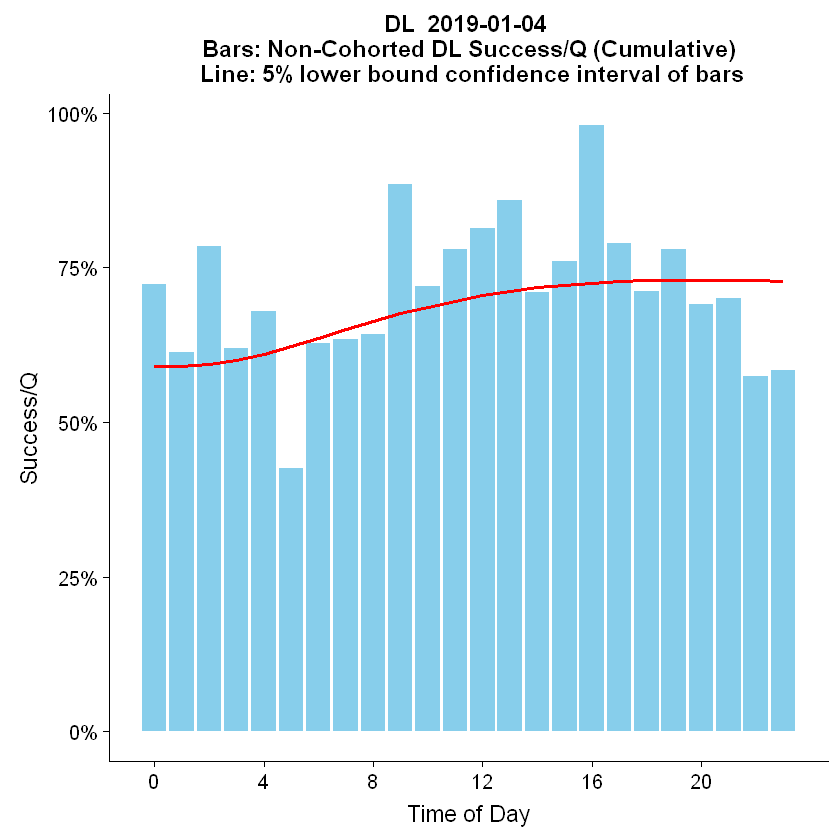

In [69]:
ggplot(
    data = ci.information.smooth,
#     data = ci.information, 
    mapping = aes(
        x = hour.session, 
        y = r.session
    )
) +
geom_col(
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "DL ", getSessionInfo()$date,
        "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
        "\n", "Line: 5% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        x = hour.session, 
        y = ci.lower
    ), 
    color = 'red', 
    size=1
) + 
# geom_line(
#     aes(
#         x = hour.session, 
#         y = ci.upper
#     ), 
#     color = 'blue', 
#     size=1
# ) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
